In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.dirname(os.path.dirname(os.path.join(os.getcwd())))))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
from torchvision.transforms import RandAugment
from torchvision import datasets, models

from model.utils import (
    get_device,
    train_model_single_epoch,
    validate_model_single_epoch,
    save_checkpoint,
    evaluate_model_with_top_k,
    plot_history,
)

In [2]:
base_dir = "../../"
    
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.Food101(root=f"{base_dir}data/food101", split="train", download=False, transform=train_transform)
test_dataset = datasets.Food101(root=f"{base_dir}data/food101", split="test", download=False, transform=val_transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])


In [4]:
# EfficientNet finetune
model = models.efficientnet_b0(pretrained=True)

num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, 101)  # 101 food classes
)

/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
device = get_device()

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
scaler = torch.amp.GradScaler("cuda")
grad_clip = 1
ckpt_dir = "checkpoints/food101_efficientnetb0"

history = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, device, scaler, grad_clip, history, ckpt_dir, num_epochs=10):
    model.train()

    for epoch in range(1, num_epochs+1):
        train_loss, train_accuracy = train_model_single_epoch(
            model, train_loader, criterion, optimizer, device, scaler, grad_clip
        )
        val_loss, val_accuracy = validate_model_single_epoch(model, val_loader, criterion, device)

        print(
            f"[Epoch {epoch}/{num_epochs}]",
            f"Train Loss: {train_loss:.4f} | " f"Train Accuracy: {train_accuracy:.4f}",
            f"Val Loss: {val_loss:.4f} | " f"Val Accuracy: {val_accuracy:.4f}"
        )

        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        save_checkpoint(epoch, model, optimizer, history, ckpt_dir)

/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [27]:
num_epochs = 20
# add augmentation
train_model(model, train_loader, test_loader, criterion, optimizer, device, scaler, grad_clip, history, ckpt_dir, num_epochs=num_epochs)

Training: 100%|██████████| 2368/2368 [15:20<00:00,  2.57it/s, loss=2.51] 


[Epoch 1/20] Train Loss: 1.9769 | Train Accuracy: 0.5035 Val Loss: 1.1569 | Val Accuracy: 0.6888
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_1


Training: 100%|██████████| 2368/2368 [15:02<00:00,  2.62it/s, loss=2.15] 


[Epoch 2/20] Train Loss: 1.3888 | Train Accuracy: 0.6376 Val Loss: 0.9021 | Val Accuracy: 0.7514
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_2


Training: 100%|██████████| 2368/2368 [14:34<00:00,  2.71it/s, loss=0.724]


[Epoch 3/20] Train Loss: 1.1930 | Train Accuracy: 0.6839 Val Loss: 0.8473 | Val Accuracy: 0.7648
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_3


Training: 100%|██████████| 2368/2368 [21:43<00:00,  1.82it/s, loss=2.55] 


[Epoch 4/20] Train Loss: 1.0690 | Train Accuracy: 0.7135 Val Loss: 0.7901 | Val Accuracy: 0.7883
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_4


Training: 100%|██████████| 2368/2368 [29:48<00:00,  1.32it/s, loss=0.592]


[Epoch 5/20] Train Loss: 0.9684 | Train Accuracy: 0.7353 Val Loss: 0.7987 | Val Accuracy: 0.7825
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_5


Training: 100%|██████████| 2368/2368 [37:50<00:00,  1.04it/s, loss=1.82] 


[Epoch 6/20] Train Loss: 0.8873 | Train Accuracy: 0.7558 Val Loss: 0.7607 | Val Accuracy: 0.7975
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_6


Training: 100%|██████████| 2368/2368 [27:10<00:00,  1.45it/s, loss=1.44] 


[Epoch 7/20] Train Loss: 0.8192 | Train Accuracy: 0.7712 Val Loss: 0.7452 | Val Accuracy: 0.7977
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_7


Training: 100%|██████████| 2368/2368 [29:39<00:00,  1.33it/s, loss=1.06] 


[Epoch 8/20] Train Loss: 0.7562 | Train Accuracy: 0.7886 Val Loss: 0.7498 | Val Accuracy: 0.8015
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_8


Training: 100%|██████████| 2368/2368 [27:16<00:00,  1.45it/s, loss=1.3]  


[Epoch 9/20] Train Loss: 0.7107 | Train Accuracy: 0.7999 Val Loss: 0.7406 | Val Accuracy: 0.8047
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_9


Training: 100%|██████████| 2368/2368 [28:17<00:00,  1.39it/s, loss=1.37] 


[Epoch 10/20] Train Loss: 0.6520 | Train Accuracy: 0.8150 Val Loss: 0.7436 | Val Accuracy: 0.8066
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_10


Training: 100%|██████████| 2368/2368 [27:10<00:00,  1.45it/s, loss=1.09] 


[Epoch 11/20] Train Loss: 0.6155 | Train Accuracy: 0.8231 Val Loss: 0.7770 | Val Accuracy: 0.8050
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_11


Training: 100%|██████████| 2368/2368 [28:27<00:00,  1.39it/s, loss=0.295]


[Epoch 12/20] Train Loss: 0.5680 | Train Accuracy: 0.8361 Val Loss: 0.7930 | Val Accuracy: 0.8030
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_12


Training: 100%|██████████| 2368/2368 [26:54<00:00,  1.47it/s, loss=0.332] 


[Epoch 13/20] Train Loss: 0.5440 | Train Accuracy: 0.8417 Val Loss: 0.8018 | Val Accuracy: 0.8014
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_13


Training: 100%|██████████| 2368/2368 [28:50<00:00,  1.37it/s, loss=1.34]  


[Epoch 14/20] Train Loss: 0.5186 | Train Accuracy: 0.8489 Val Loss: 0.7853 | Val Accuracy: 0.8080
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_14


Training: 100%|██████████| 2368/2368 [27:03<00:00,  1.46it/s, loss=0.0864]


[Epoch 15/20] Train Loss: 0.4801 | Train Accuracy: 0.8586 Val Loss: 0.8110 | Val Accuracy: 0.8053
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_15


Training: 100%|██████████| 2368/2368 [28:42<00:00,  1.37it/s, loss=1.9]   


[Epoch 16/20] Train Loss: 0.4587 | Train Accuracy: 0.8639 Val Loss: 0.8247 | Val Accuracy: 0.8056
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_16


Training: 100%|██████████| 2368/2368 [27:18<00:00,  1.45it/s, loss=1]     


[Epoch 17/20] Train Loss: 0.4380 | Train Accuracy: 0.8693 Val Loss: 0.8429 | Val Accuracy: 0.8019
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_17


Training: 100%|██████████| 2368/2368 [28:30<00:00,  1.38it/s, loss=0.901] 


[Epoch 18/20] Train Loss: 0.4177 | Train Accuracy: 0.8763 Val Loss: 0.8816 | Val Accuracy: 0.8042
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_18


Training: 100%|██████████| 2368/2368 [27:33<00:00,  1.43it/s, loss=1.54]  


[Epoch 19/20] Train Loss: 0.3950 | Train Accuracy: 0.8822 Val Loss: 0.8655 | Val Accuracy: 0.8038
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_19


Training: 100%|██████████| 2368/2368 [28:32<00:00,  1.38it/s, loss=0.884] 


[Epoch 20/20] Train Loss: 0.3738 | Train Accuracy: 0.8859 Val Loss: 0.8667 | Val Accuracy: 0.8060
Model checkpoint saved at checkpoints/food101_efficientnetb0/ckpt_20


### Model evaluation

In [6]:
class_mapping = {}
with open(f'{base_dir}data/food101/food-101/meta/classes.txt', 'r') as file:
    classes = file.read().splitlines()
    for index, class_name in enumerate(classes):
        class_mapping[index] = class_name

In [7]:
ckpt = torch.load(f"{base_dir}saved_models/food101/ckpt_best")
model.load_state_dict(ckpt['model_state_dict'])
model.to(device)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [8]:
print("Train set: ")
evaluate_model_with_top_k(model, train_loader, device, class_mapping.values())

Train set: 
Top-1 Accuracy: 0.8771
Top-5 Accuracy: 0.9776
Classification Report:
                         precision    recall  f1-score   support

              apple_pie       0.90      0.70      0.79       750
         baby_back_ribs       0.90      0.85      0.87       750
                baklava       0.90      0.91      0.90       750
         beef_carpaccio       0.85      0.92      0.88       750
           beef_tartare       0.95      0.80      0.87       750
             beet_salad       0.78      0.88      0.83       750
               beignets       0.91      0.90      0.91       750
               bibimbap       0.96      0.93      0.94       750
          bread_pudding       0.81      0.80      0.80       750
      breakfast_burrito       0.87      0.86      0.86       750
             bruschetta       0.81      0.84      0.83       750
           caesar_salad       0.92      0.88      0.90       750
                cannoli       0.92      0.90      0.91       750
        

In [9]:
print("Test set: ")
evaluate_model_with_top_k(model, test_loader, device, class_mapping.values())

Test set: 
Top-1 Accuracy: 0.8047
Top-5 Accuracy: 0.9532
Classification Report:
                         precision    recall  f1-score   support

              apple_pie       0.72      0.52      0.61       250
         baby_back_ribs       0.88      0.70      0.78       250
                baklava       0.84      0.90      0.87       250
         beef_carpaccio       0.81      0.90      0.86       250
           beef_tartare       0.80      0.69      0.74       250
             beet_salad       0.73      0.73      0.73       250
               beignets       0.85      0.82      0.84       250
               bibimbap       0.93      0.91      0.92       250
          bread_pudding       0.68      0.65      0.66       250
      breakfast_burrito       0.77      0.68      0.72       250
             bruschetta       0.74      0.76      0.75       250
           caesar_salad       0.85      0.87      0.86       250
                cannoli       0.83      0.82      0.83       250
         

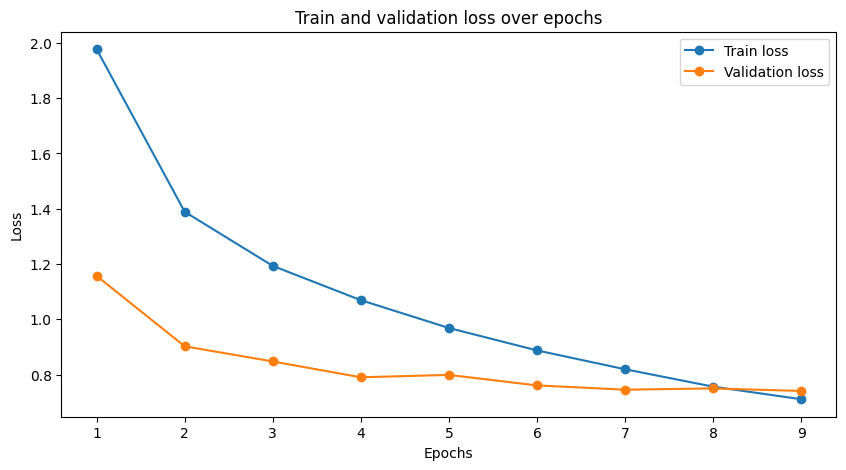

In [10]:
history = ckpt['history']
plot_history(history, 'loss')

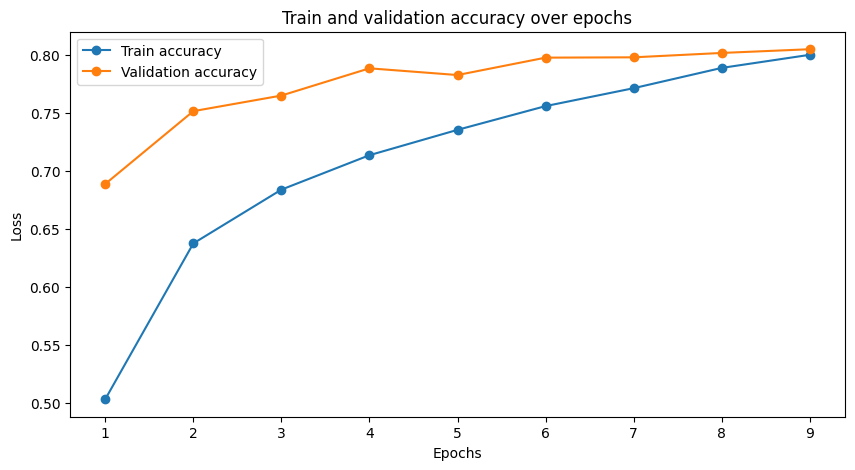

In [11]:
plot_history(history, 'accuracy')